## **Classic AI Challenge**

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


**Data Preprocessing**


1. Data is loaded from the csv file

In [87]:
file ="./data/data.csv"

data = pd.read_csv(file, delimiter=',')

print(data.columns)

Index(['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'],
      dtype='object')


2. Unnecessary columns are removed & renamed them in English

In [88]:
data = data[['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT']]

data.columns = ['Category', 'Type', 'Year', 'Month', 'Value']

3. All entries with year > 2020 are removed

In [89]:
# Preserving the original data for later calculations of the error between the prediction and the ground truth
mse_data = data.copy()

data = data[(data['Category'] == "Alkoholunfälle") & 
            (data['Year'] <= 2020) & 
            (data['Month'] != "Summe") & 
            (data['Type'] == "insgesamt")]
print(data.head(1))

          Category       Type  Year   Month  Value
51  Alkoholunfälle  insgesamt  2020  202001   28.0


4. The month column is formatted and a new column for the date is created

In [90]:
data =data.sort_values(by=['Month'])

# Extract the month from the Month column
data['Month'] = data['Month'].str[4:]

# Create a new column with the date
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str), format='%Y-%m')

print(data.head(1))

           Category       Type  Year Month  Value       Date
310  Alkoholunfälle  insgesamt  2000    01   78.0 2000-01-01



**Data Visualization**


In [91]:
# Define function for plotting the data
def plot_function(plot_data, color=None):
    for year in plot_data['Year'].unique():
        year_data = plot_data[plot_data['Year'] == year]
        plt.step(
            year_data['Date'],
            year_data['Value'],
            label=str(year),
            where='post',
            color=color
        )
# Define function for plotting the data having the date as index
def plot_function_index(plot_data, color=None):
    for year in plot_data['Year'].unique():
        year_data = plot_data[plot_data['Year'] == year]
        plt.step(
            year_data.index,
            year_data['Value'],
            label=str(year),
            where='post',
            color=color
        )

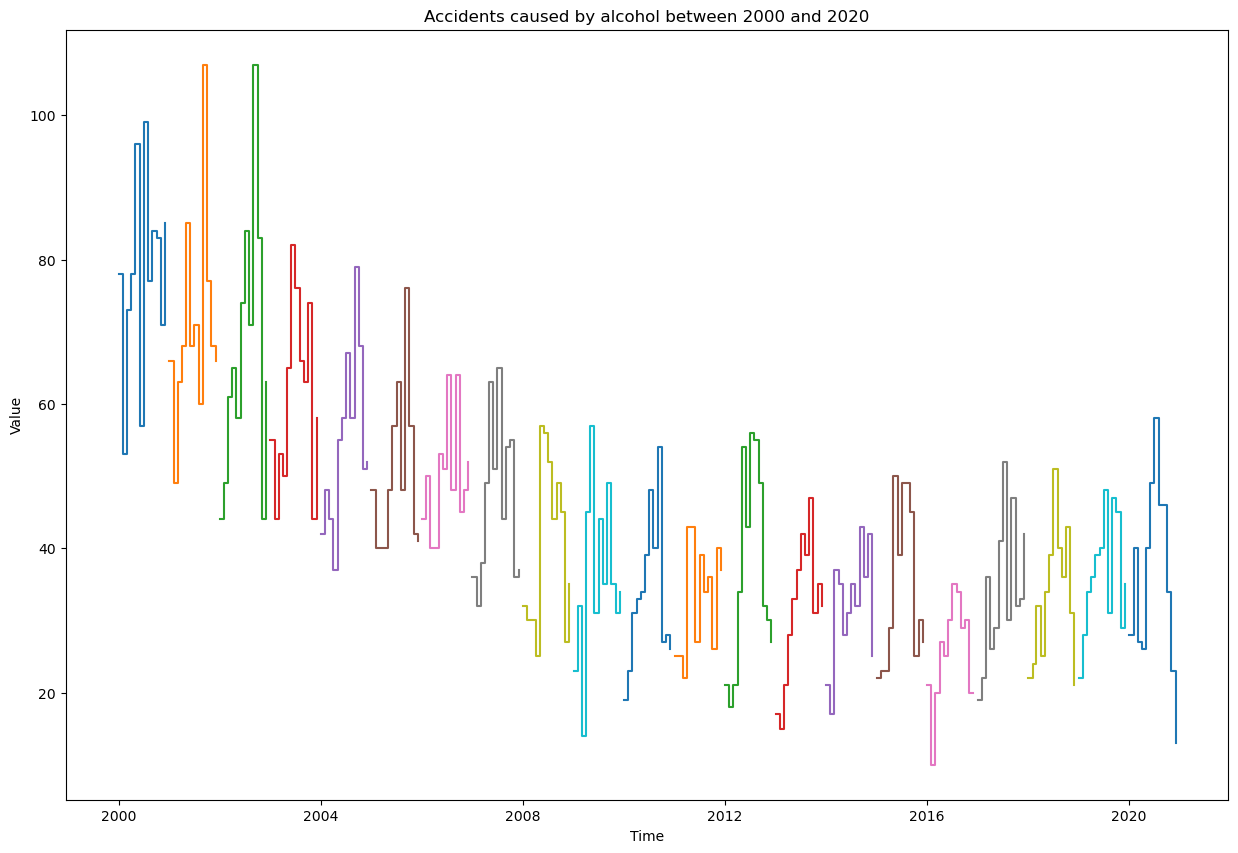

In [92]:
plt.figure(figsize=(15, 10))

plot_function(data)

plt.title('Accidents caused by alcohol between 2000 and 2020')

plt.xlabel('Time')
plt.ylabel('Value')

plt.show()


**Forecasting**


3. Import SARIMAX Model

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

4. Train the Model

In [94]:
data.set_index('Date', inplace=True)
input_data = data['Value'].asfreq('MS')

# order=(p,d,q):
# p=2 meaning that the model uses 2 previous month to predict the next one
# d=1  differencing once to make the series stationary 
# q=2 considers unexpected changes from 2 previous month

# seasonal_order=(P,D,Q,s): 
# P=4 uses the same month from previous 4 years 
# D=1 seasonal differencing 
# Q=1 considers unexpected changes from 1 previous month 
# s=12 because there is a new year every 12 months

SARIMAXmodel = SARIMAX(input_data,
                order=(2, 1, 2),          
                seasonal_order=(4, 1, 1, 12))

SARIMAXmodel = SARIMAXmodel.fit()

4. Save the trained model

In [95]:
import pickle

In [96]:
# Save the trained model
with open('../sarimax_model.pkl', 'wb') as f:
    pickle.dump(SARIMAXmodel, f)

5. Get Forecast

In [97]:
forecast_date = pd.date_range(start='2021-01-01', end='2021-01-31', freq='MS')

# Forecast for January 2021
forecast = SARIMAXmodel.forecast(steps=1, index=forecast_date)
print(f'Forecast for January 2021: {forecast}')

Forecast for January 2021: 2021-01-01    23.254985
Freq: MS, dtype: float64


6. Plot forecast

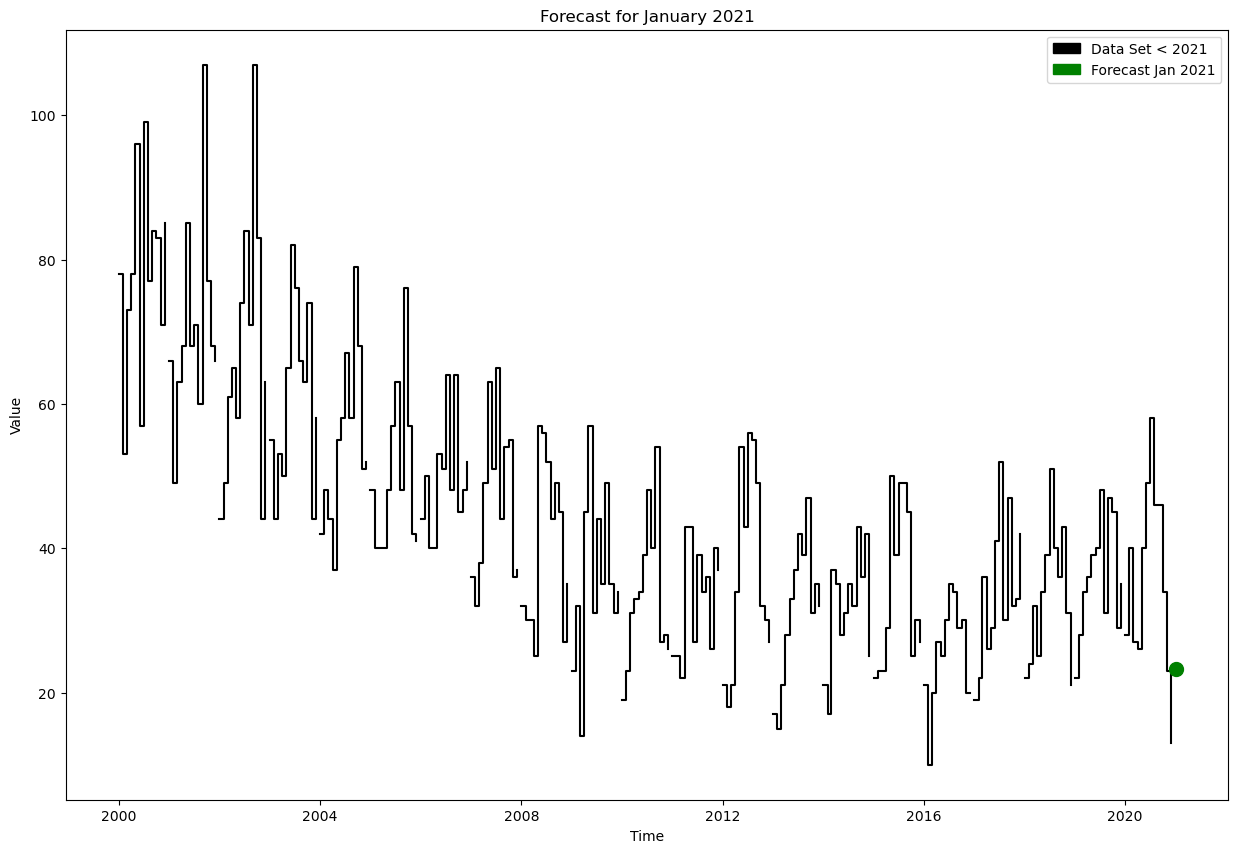

In [98]:
plt.figure(figsize=(15, 10))

# Plot training set
plot_function_index(data, color='black')

# Add forecast point
plt.plot(forecast, 
         'go',  # green dot
         markersize=10,
         label='Forecast Jan 2021')

black_patch = mpatches.Patch(color='black', label='Data Set < 2021')
green_patch = mpatches.Patch(color='green', label='Forecast Jan 2021')

plt.legend(handles=[black_patch, green_patch])

plt.title('Forecast for January 2021')

plt.xlabel('Time')
plt.ylabel('Value')

plt.show()


**Evaluation of the Forecast**


In [99]:
# Extract the entry for January 2021
mse_data = mse_data[(mse_data['Category'] == "Alkoholunfälle") & (mse_data['Type'] == "insgesamt") & (mse_data['Month'] == "202101")]

# Print the ground truth value
print(f'Ground Truth: {mse_data["Value"].values[0]}')

# Calculate the error
print(f'Absolute error: {abs(forecast - mse_data["Value"].values[0])}')

Ground Truth: 16.0
Absolute error: 2021-01-01    7.254985
Freq: MS, dtype: float64


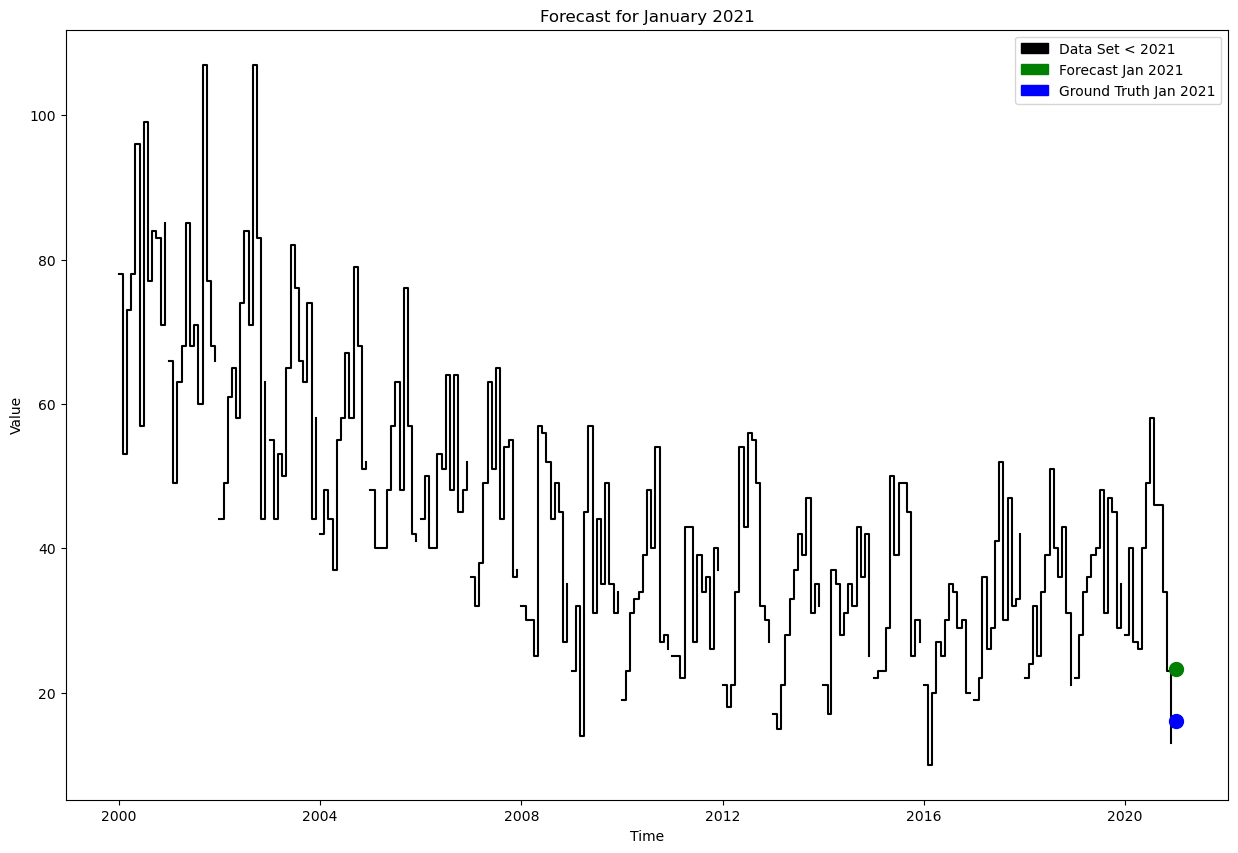

In [100]:
plt.figure(figsize=(15, 10))

# Plot training set
plot_function_index(data, color='black')

# Add forecast point
plt.plot(forecast, 
         'go',  # green dot
         markersize=10,
         label='Forecast Jan 2021')


mse_data['Month'] = mse_data['Month'].str[4:]

mse_data['Date'] = pd.to_datetime(mse_data['Year'].astype(str) + '-' + mse_data['Month'].astype(str), format='%Y-%m')

plt.plot( mse_data['Date'],
         mse_data['Value'],
         'bo',  # blue dot
         markersize=10,
         label='Forecast Jan 2021')

blue_patch = mpatches.Patch(color='blue', label='Ground Truth Jan 2021')

plt.legend(handles=[black_patch, green_patch, blue_patch])

plt.title('Forecast for January 2021')

plt.xlabel('Time')
plt.ylabel('Value')

plt.show()

**Inspiration(s)**

https://builtin.com/data-science/time-series-forecasting-python